In [24]:
#This cell imports packages required
import sys
#This sets the path. Ensure you have added the path to the data to the file library/pathy.py
sys.path.append("library")
import numpy as np
from scipy import io
from pyls.structures import PLSInputs
import pandas as pd
import matplotlib.pyplot as plt
import pyls
import paths
import os

In [26]:
#import parcellated lesion maps
FCD=np.loadtxt(os.path.join(paths.BASE_PATH,'..','lesion_characteristics/data/histology_subtypes/HCP_all_patients_mean_per_area.txt'))


In [27]:
#remove medial wall
FCD=FCD[:,1:]

In [28]:
#import Allen Gene expression data
gene_exp=io.loadmat('data/AHBAdata.mat')
#create mask nan parcels
mask=~np.isnan(gene_exp['parcelExpression'].T[1])

In [9]:
#z score gene expressions
z_gene_exp=(gene_exp['parcelExpression'][mask]-np.mean(gene_exp['parcelExpression'][mask],axis=0))/np.std(gene_exp['parcelExpression'][mask],axis=0)

In [10]:
#extract gene_names
gene_names=np.zeros(len(gene_exp['parcelExpression'].T)).astype(str)
gene_names[0]='Gene'
for k,probe in enumerate(gene_exp['probeInformation'][0][0][1]):
    gene_names[k+1]=str(probe[0][0])

In [284]:
#set up dataset
pls_dataset=PLSInputs()
#X - gene expression
pls_dataset['X']= pd.DataFrame(z_gene_exp[:,1:], columns=gene_names[1:])
#Y - lesions
pls_dataset['Y']=np.expand_dims(FCD[:,mask].T,1)
#Number of permutations
pls_dataset['n_perm']=1000
#Number of bootstraps
pls_dataset['n_boot']=1000
#How many components to calculate
pls_dataset['n_components']=5

In [ ]:
#Run PLS
plsr1 = pyls.pls_regression(**pls_dataset, seed=1234,agg_func='mean')

Running permutations:  56%|#####5    | 558/1000 | 02:05<01:52

In [14]:

plsr1['bootres']['x_weights_normed']

array([[ 9.62865731, -4.83966553,  0.51458518, -1.09439025, -2.15680906],
       [-0.03290777,  0.443708  ,  0.60809083,  1.2210909 ,  0.07032312],
       [-1.10521036,  2.06216198,  4.71880482, -3.30611799, -1.41363031],
       ...,
       [ 3.80368539,  0.19875698, -0.07500438,  1.63380007,  1.82057976],
       [-7.04185313,  3.50197587,  1.59694885,  0.69966237, -0.35388383],
       [ 2.59365147, -5.75892184, -3.27763277,  2.65472439,  0.51107001]])

In [48]:
#correlations with components
r_corrs=np.zeros(pls_dataset['n_components'])
for k in np.arange(pls_dataset['n_components']):
    r_corrs[k]=np.corrcoef(plsr1['x_scores'][:,k].T,np.mean(pls_dataset['Y'],axis=2).T)[1,0] 
#Cumulative sum
cs=np.cumsum(plsr1['varexp'])
cs=np.insert(cs,0,0)

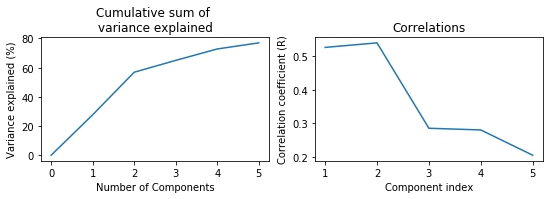

In [59]:
#Plot variance explained and correlations
plt.figure(figsize=(9,5))
plt.subplot(221)
plt.title('Cumulative sum of \nvariance explained')
plt.plot(cs*100)
plt.xticks(np.arange(len(cs)))
plt.xlabel('Number of Components')
plt.ylabel('Variance explained (%)')
plt.subplot(222)
plt.title('Correlations')
plt.ylabel('Correlation coefficient (R)')
plt.xlabel('Component index')
plt.plot(np.arange(len(r_corrs))+1,np.abs(r_corrs))

In [60]:
##Enrichments

In [272]:
#Get sorted list of values
#QQ petra - should these be absolute?
absolute_values=np.abs(plsr1['x_weights'])
components=[]
for comp in np.arange(pls_dataset['n_components']):
    components.append(gene_names[np.argsort(absolute_values[:,comp])].tolist())
    np.savetxt('data/component_{}.txt'.format(comp),components[comp],fmt='%s')

In [259]:
#functions for enrichment analyses
def get_gene_indices(component_genes_sorted,gene_list):
    """get indices of genes in a list"""
    indices=[]
    for k,gene_name in enumerate(gene_list):
        try:
            indices.append(component_genes_sorted.index(gene_name))
        except ValueError:
            print('{} not found in Allen gene list'.format(gene_name))
    indices.sort()
    return np.array(indices)

def gene_position_plots(component_genes_sorted, gene_list, n_components=3):
    """plot index of gene list lines and chance line to see if more than chance"""
    for c_i in range(n_components):
        gene_indices=get_gene_indices(component_genes_sorted[c_i], gene_list)
        plt.plot(np.arange(len(gene_indices)),gene_indices/len(component_genes_sorted[0]))
        
        #diff=(gene_indices/len(component_genes_sorted[0]))-np.arange(len(t))*increment
        #print(np.sum(diff))
    increments=1/len(gene_indices)
    plt.plot(np.arange(len(gene_indices)), increments/2 + increments*np.arange(len(gene_indices)), color='black')
    legend=list(np.arange(n_components))
    legend.append('random')
    plt.legend(legend)
    return

In [ ]:
## QQ petra - test for chance

CDK2 not found in Allen gene list
EIF4A1 not found in Allen gene list
PLD2 not found in Allen gene list
SSPO not found in Allen gene list
CDK2 not found in Allen gene list
EIF4A1 not found in Allen gene list
PLD2 not found in Allen gene list
SSPO not found in Allen gene list
CDK2 not found in Allen gene list
EIF4A1 not found in Allen gene list
PLD2 not found in Allen gene list
SSPO not found in Allen gene list


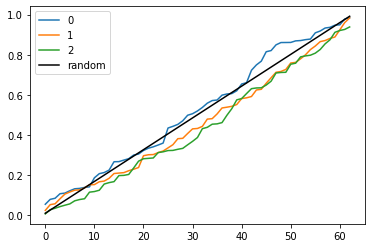

In [261]:
#MTOR pathway
import json

with open('data/mtor_PID.json') as json_file:
    data = json.load(json_file)
mtor_pathway_names=[]
for gene in data['associations']:
    mtor_pathway_names.append(gene['gene']['symbol'])
mtor_pathway_names.sort()
gene_position_plots(components, mtor_pathway_names)

In [262]:
#random iterations for p values??
# diffs=np.zeros(1000)
# for k in np.arange(1000):
#     t_rand=np.random.choice(len(components[0]),size=len(t), replace=False)
#     t_rand.sort()
#     plt.plot(np.arange(len(t)),t_rand/len(components[0]))
#     diffs[k]=np.sum((t_rand/len(components[0]))-np.arange(len(t))*increment)

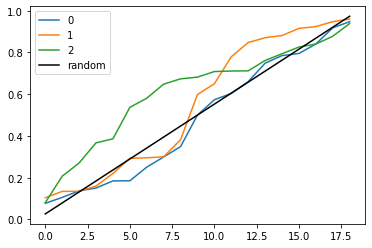

In [263]:
# restricted mtor genes

#Restricted mtor gene list
mtor_restricted=np.loadtxt('data/fcd_genes.txt',dtype='str')
gene_position_plots(components, mtor_restricted)

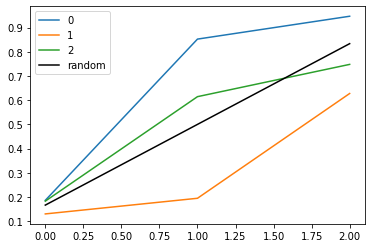

In [265]:
#subunits from the GABA BZ receptor
gaba_gene_list=['GABRA1','GABRB2', 'GABRG2']
gene_position_plots(components, gaba_gene_list)

In [278]:
#all gaba receptor genes
gabr=[]
for gene in components[0]:
    if "GABR" in gene:
        gabr.append(gene) 

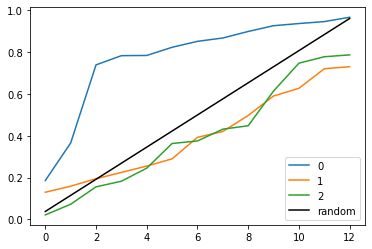

In [283]:
gene_position_plots(components, gabr)